# Chapter 10 - Working with unlabled data: clustering analysis

*Unsupervised learning*: techniques of finding patters in data that is unlabeled.

*Clustering*: an unsupervised learning technique that finds groups of data that are similar.

Other important points:
- *K-means* to find centers of similarities in data
- Bottom-up approach of clustering using hierachical clustering tress
- Finding arbitrary shapes in data using density based clustering

## Grouping objects by similarity using k-means

### k-means clustering using scikit-learn

K-means is a *prototype-based clustering* algorithm, meaning that each cluster is represented by a prototype; this prototype is typically defined as the *centroid* (the average of a continuous feature) or the *medoid* (the most representative categorical point which minimizes distances to all other points). Note that the number of clusters is a hyperparameter which needs to be decided by some metric evlatuation. 

K-means is summarized in the following steps:
1. Pick $k$ random centroids
2. ASsign each example to the nearest centroid, $\mu^{(j)}, j \in {1, \dots , k}$
3. Move the centroid to the center of the examples that were assigned to it
4. Repeat steps 2 and 3 until centroids no longer move or a maximum number of iterations is reached

Generally the measure of similarity is the squared eclidean distance between points:
$$
    d(x, y)^2 = \sum_{j = 1}^m (x_j - y_j)^2 = \|x - y\|^2_ 2
$$
for the $j$th dimension o the example inputs. Based on this the k-means can be understood as an optimization probem for the sum of square errors (a.k.a. the cluster intertia):
$$
    SSE = \sum_{i=1} ^n \sum_{j=1}^k w^{(i, j)} \|x^{(i)} - \mu^{(j)}\|^2_2
$$
where $\mu^{(j)}$ is a representative point for cluster $j$ and 
$$
    w^{(i, j)} = \begin{cases}
                    1 & \text{if } x^{(i)} \in j \\
                    0 & \text{otherwise}
                 \end{cases}
$$

To illustrate, create a dataset with clusters:

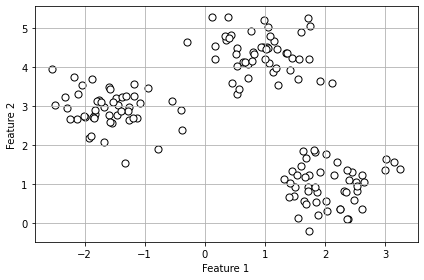

In [1]:
from sklearn.datasets import make_blobs 
X, y = make_blobs(n_samples=150,
    n_features=2,
    centers=3,
    cluster_std=0.5,
    shuffle=True,
    random_state=0) 
import matplotlib.pyplot as plt 
plt.scatter(X[:, 0],
    X[:, 1],
    c='white',
    marker='o',
    edgecolor='black',
    s=50)
plt.xlabel('Feature 1') 
plt.ylabel('Feature 2') 
plt.grid()
plt.tight_layout()
plt.show()

Now apply the `KMeans` from scikit-learn:

In [25]:
from sklearn.cluster import KMeans 
km = KMeans(n_clusters=3,
    init='random',
    n_init=10, #run the algorithm 10 times with different initial centroids
    max_iter=300, #will stop if it converges before this point
    tol=1e-04,
    random_state=0) 
y_km = km.fit_predict(X)

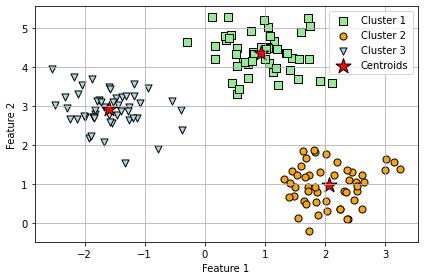

In [3]:
plt.scatter(X[y_km == 0, 0],
    X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='Cluster 1') 
plt.scatter(X[y_km == 1, 0],
    X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='Cluster 2') 
plt.scatter(X[y_km == 2, 0],
    X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='Cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='Centroids') 
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(scatterpoints=1) 
plt.grid()
plt.tight_layout()
plt.show()

It works well; but the drawback is having to decide on $k$. 

### A smarter way of placing the initial cluster centroids using k-means++

The *k-means++* algorithm places the initial centroids as far away from each other, which to better and more consistent results.  The algorithm can be summarized in the following steps:
1. Initialize $M$, and empty set to store $k$ centroids
2. Randomly choose the first centroid, $\mu^{(j)}$, from input examples and assign it to $M$
3. For every example, $x^{(i)}$, not in $M$, find the minimum square distance, $d(x^{(i)}, M)^2$, to and of the centroid in $M$.
4. To assign the next centroid, $\mu^{(p)}$, use a weighted probability distibution equal to
$$
    \frac{d(\mu^{(p)}, M)^2}{\sum_i d(x^{(i)}, M)^2}
$$
5. Repeat steps 3 and 4 until $k$ centroids are chosen
6. Proceed with the basic k-means algorithm

To use the algorithm with `KMeans`, use `init='k-means++'`.

### Hard versus soft clustering

*Hard clustering* assigns every example in a dataset to a single cluster; *soft clustering* or *fuzzy clustering* assigns examples to one or more clusters. An example of soft clustering is *fuzzy C-means* (FCM), which is similar to k-means clustering.  In fuzzy C-means probabilities are assigned to each example.  The algorithm can be summarized as follows:
1. Specify $k$ centroids and randomly assign examples to clsuters
2. Compute centroids, $\mu^{(j)}$ where $j \leq k$.
3. Update cluster membership
4. Repeat 2 and 3 for $n$ interations or until convergence

Then the cluster membership vector can be represented as
$$
    \left[ \begin{matrix}
            x \in \mu^{(1)} \to w^{(i, j)} = 0.1 \\
            x \in \mu^{(2)} \to w^{(i, j)} = 0.85 \\
            x \in \mu^{(3)} \to w^{(i, j)} = 0.05
        \end{matrix}\right]
$$

The objective function can be defined as
$$
    J_m = \sum_{i=1}^n \sum_{j=1}^k w^{(i, j)^m} \|x^{(i)} - \mu^{(j)}\|^2_2
$$
where the exponent, $m \geq 1$, is the *fuzziness coefficient* with a typical value of 2. The larger value of $m$ leads to fuzzier clsuters:
$$
    w^{(i, j)} = \left[\sum_{c=1}^k \frac{\|x^{(i)} - \mu^{(j)}\|_2}{\|x^{(i)} - \mu^{(c)}\|_2}^{\frac{2}{m-1}}\right]^{-1}
$$
and the centroid is a weighted mean:
$$
    \mu^{j} = \frac{\sum_{i=1}^n w^{(i, j)^m} x^{(i)}
                    }{
                    \sum_{i=1}^n w^{(i, j)^m}
                    }
$$

### Using the elbow method to find the optimal number of clusters

Because there are an unknown number of clusters, we need to use intrinsic metric to determine the most efficient number of clusters; for example, within cluster SSE. The scikit-learn has `interia_` attribute.

In [4]:
print(f'Distortion: {km.inertia_:.2f}')

Distortion: 72.48


As can be seen from the elbow plot below, the most efficient number of clusters is 3.

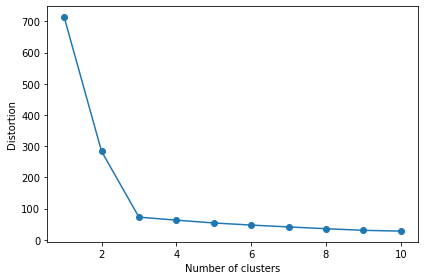

In [6]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init = 10,
                max_iter = 300,
                random_state = 0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o') 
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

### Quantifying the quality of clustering via silouette plots

*Silouette analysis* is a visual representation of how tightly grouped a cluster is. It uses the *silhouette coefficient* which is calculated as follows:
1. Calculate *cluster cohesion*, $a^{(i)}$, as the average distance between an example and all other cluster members
2. Calculate *cluster seperation*, $b^{(i)}$, as the average distance between an example and the examples in the nearest clsuter (how is nearness determined? by the nearest centroid?)
3. Calculate the silhouette coefficient as 
$$
    s^{(i)} = \frac{b^{(i)} - a^{(i)}}{\text{max}\{b^{(i)}, a^{(i)}\}}
$$
The closer to 1 $s$ is and if $b^{(i)} >> a^{(i)}$, the clusters are more different.

`silhouette_scores` can be used from scikit-learn's `metric` module.

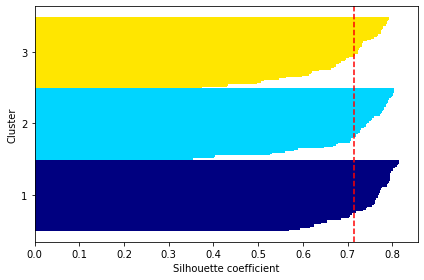

In [7]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0) 
y_km = km.fit_predict(X)
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples 
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(
    X, y_km, metric='euclidean'
    )
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()

    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
         c_silhouette_vals,
         height=1.0,
         edgecolor='none',
         color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals) 
plt.axvline(silhouette_avg,
    color="red",
    linestyle="--")
plt.yticks(yticks, cluster_labels + 1) 
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient') 
plt.tight_layout()
plt.show()

Note that the silhouette scores are far from zero and about equally far from the average silhouette score.  This indicates good clustering. 

## Organizing clusters as a hierarchical tree

*Hierarchical clustering* comes in two types:
1. *Divisive*: Split the dataset into smaller and smaller subsets until only individual examples are available
1. *Agglomerative*: Join the individual examples of data into larger and larger datasets

Hierarchical clustering has the advantage of *dendrograms* which visualize the splits in the data to form the clusters.

### Grouping clusters in a bottom up fashion

There are two main algorithms for agglomerative clustering:
1. *Single linkage*: merge based on the most similar examples
2. *Complete linkage*: merge based on most dissimilar examples

There are other types of linakges too. For example:
- *average linkage*: merge based on the minimal average distance between two clusters
- *Ward's linakge*: merge on the clusters with the minimal increase in the total within-cluster SSE

Complete linkage for the agglomerative algorithm can be summarized as follows:
1. Compute a pairwise distance matrix
2. Assume every datapoint is a singleton cluster
3. Merge the two nearest clusters based on the most dissimilar members
4. Update cluster linkage matrix
5. Repeat 2-4 until one cluster remains

Generate random data:

In [1]:
import pandas as pd
import numpy as np
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4'] 
X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels) 
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


### Perform hierarchical clustering on a distance matrix

`scipy` can be used to generate a distance matrix.

In [2]:
from scipy.spatial.distance import pdist, squareform 
row_dist = pd.DataFrame(squareform(
    pdist(df, metric='euclidean')),
    columns=labels, index=labels) 
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


Use scipy to do the linkage operation

In [3]:
from scipy.cluster.hierarchy import linkage

Note the help for the function.  Note that under `parameters` a squareform matrix cannot be used in the function.  It must either be upper triangular form, or the initial data array (then use `euclidean`. row_clusters = linkage(pdist(df, metric='euclidean'), ... method='complete')

In [5]:
#help(linkage)

In [7]:
#incorrect
#cannot pass the square form (the one with a zero diagonal)
#this will produce results, but they wil be incorrect
#row_clusters = linkage(row_dist, method='complete', metric='euclidean')

#correct forms
#pdist returns an upper triangular form
row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
#pass the df and use the euclidean metric
row_clusters = linkage(df.values, method='complete', metric='euclidean')

Now examine the clusters.  Each row represents a merge.  `row label X` represents the most similar and most dissimilar members, and `distance` is the distance between the most dissimilar members (the one in the `row label X`.

In [8]:
pd.DataFrame(row_clusters,
            columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'], 
            index=[f'cluster {(i + 1)}' for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


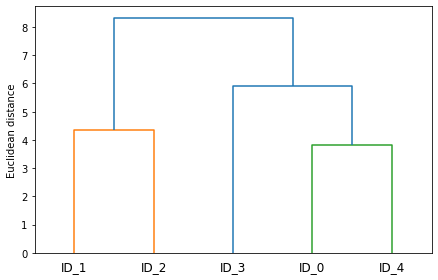

In [11]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette 
# set_link_color_palette(['black'])
row_dendr = dendrogram(
    row_clusters,
    labels=labels,
    # make dendrogram black (part 2/2)
    # color_threshold=np.inf ... 
)
plt.tight_layout()
plt.ylabel('Euclidean distance') 
plt.show()

## Attaching dendrograms to a heat map

Four steps

1. create a `figure` object with the defined dendrograms x and y axis, height and width. And rotate the dendrogram 90 degrees.

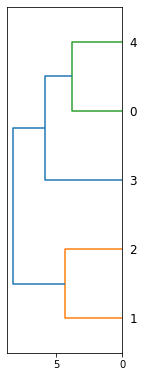

In [12]:
fig = plt.figure(figsize=(8, 8), facecolor='white') 
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')

2. Reorder data according to cluster labels stored in the dendrogram object.

In [13]:
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

3. Now construct a heatmap

In [17]:
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6]) 
cax = axm.matshow(df_rowclust,
    interpolation='nearest',
    cmap='hot_r')

4. display the plot.

In [15]:
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns)) 
axm.set_yticklabels([''] + list(df_rowclust.index)) 
plt.show()

### Applying agglomerative clustering via sci-kit learn

Scikit learn has `AgglomerativeClustering`.  Use `n_clusters` to set the number of clusters.


In [21]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3,
    affinity='euclidean',
    linkage='complete') 
labels = ac.fit_predict(X)
print(f'Cluster labels: {labels}')

Cluster labels: [1 0 0 2 1]


Note that the results are consistent with scipy.  Run with 2 clusters:

In [22]:
ac = AgglomerativeClustering(n_clusters=2,
    affinity='euclidean',
    linkage='complete')
labels = ac.fit_predict(X)
print(f'Cluster labels: {labels}')

Cluster labels: [0 1 1 0 0]


## Locating region of high density via DBSCAN

*Density-based spatial clustering of applications with noise* (DBSCAN). Density is defined as the number of examples within $\epsilon$ radius.  

DBSCAN assigns a label to data based on the following criteria:
- A point is considered a *core point* if a specified number of points (MinPts) fall within $\epsilon$ radius
- A *border point* is considered a point with less than MinPts within $\epsilon$ radius
- Other points are *noise points*

The algorithm can be described in two steps:
1. Form a cluster for each core point or connected number of core points (when two core points are within an $\epsilon$ radius)
2. Assign border points to a corresponding core point cluster

Note that clusters are not assumed to be spheroid, as in k-means. Moreover, not all points are assigned; but rather there remain noise points. 

Consider the following data which is hard to cluster via spheroids:

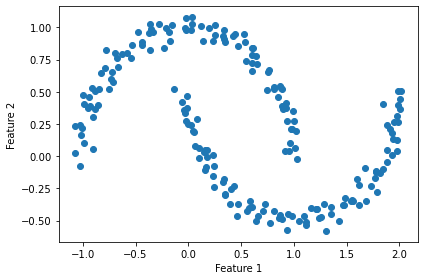

In [23]:
from sklearn.datasets import make_moons 
X, y = make_moons(n_samples=200,
    noise=0.05,
    random_state=0)
plt.scatter(X[:, 0], X[:, 1]) 
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

It is clear that the spheroid clustering does not work.

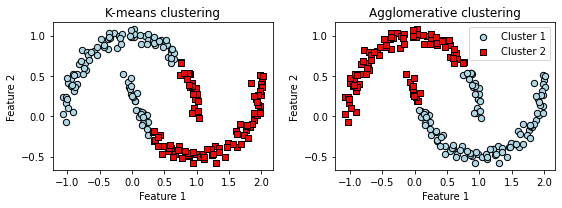

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3)) 
km = KMeans(n_clusters=2,
    random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0],
    X[y_km == 0, 1],
    c='lightblue',
    edgecolor='black',
    marker='o',
    s=40,
    label='cluster 1')
ax1.scatter(X[y_km == 1, 0],
    X[y_km == 1, 1],
    c='red',
    edgecolor='black',
    marker='s',
    s=40,
    label='cluster 2')
ax1.set_title('K-means clustering') 
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ac = AgglomerativeClustering(n_clusters=2,
    affinity='euclidean',
    linkage='complete') 
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0],
    X[y_ac == 0, 1],
    c='lightblue',
    edgecolor='black',
    marker='o',
    s=40,
    label='Cluster 1') 
ax2.scatter(X[y_ac == 1, 0],
    X[y_ac == 1, 1],
    c='red',
    edgecolor='black',
    marker='s',
    s=40,
    label='Cluster 2')
ax2.set_title('Agglomerative clustering') 
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

Compare the DBSCAN results:

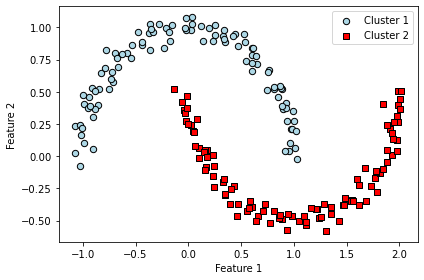

In [27]:
from sklearn.cluster import DBSCAN 
db = DBSCAN(eps=0.2,
    min_samples=5,
    metric='euclidean') 
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0],
    X[y_db == 0, 1],
    c='lightblue',
    edgecolor='black',
    marker='o',
    s=40,
    label='Cluster 1') 
plt.scatter(X[y_db == 1, 0],
    X[y_db == 1, 1],
    c='red',
    edgecolor='black',
    marker='s',
    s=40,
    label='Cluster 2') 
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

Note that DBSCAN suffers from the curse of dimensionality (this is also a problem with k-means). The curse of dimensionality can be reduced by using dimensionality reduction techniques that are also unsupervised (for example t-SNE) In addition, DBSCAN has two hyperparameters: `eps` ($\epsilon$) and `min_samples`.

It is also common to reduce data to two-dimensional subsets. 